In [ ]:
from IPython.display import Image


In [1]:
%%html
<iframe src="https://xgboost.readthedocs.io/en/latest/tutorials/model.html" width="1100" height="1000"></iframe>


# Data 

https://www.kaggle.com/c/the-winton-stock-market-challenge/data

Updated 2015-12-21: Winton have added new data into the test set. If you downloaded the test set before 2015-12-21 please re-download the data set and submit predictions on this instead. 

In this competition the challenge is to predict the return of a stock, given the history of the past few days. 

We provide 5-day windows of time, days D-2, D-1, D, D+1, and D+2. You are given returns in days D-2, D-1, and part of day D, and you are asked to predict the returns in the rest of day D, and in days D+1 and D+2.

During day D, there is intraday return data, which are the returns at different points in the day. We provide 180 minutes of data, from t=1 to t=180. In the training set you are given the full 180 minutes, in the test set just the first 120 minutes are provided.

For each 5-day window, we also provide 25 features, Feature_1 to Feature_25. These may or may not be useful in your prediction.

### Note
***Each row in the dataset is an arbitrary stock at an arbitrary 5 day time window***.



# File descriptions
***train.csv*** - the training set, including the columns of:
* Feature_1 - Feature_25
* Ret_MinusTwo, Ret_MinusOne
* Ret_2 - Ret_120
* Ret_121 - Ret_180: ***target variables***
* Ret_PlusOne, Ret_PlusTwo: ***target variables***
* Weight_Intraday, Weight_Daily

***test.csv*** - the test set, including the columns of:

* Feature_1 - Feature_25
* Ret_MinusTwo, Ret_MinusOne
* Ret_2 - Ret_120

***sample_submission.csv*** - a sample submission file in the correct format


Data fields
Feature_1 to Feature_25: different features relevant to prediction
Ret_MinusTwo:  this is the return from the close of trading on day D-2 to the close of trading on day D-1 (i.e. 1 day)
Ret_MinusOne: this is the return from the close of trading on day D-1 to the point at which the intraday returns start on day D (approximately 1/2 day)
Ret_2 to Ret_120: these are returns over approximately one minute on day D. Ret_2 is the return between t=1 and t=2. 
Ret_121 to Ret_180: intraday returns over approximately one minute on day D. These are the target variables you need to predict as {id}_{1-60}. 
Ret_PlusOne: this is the return from the time Ret_180 is measured on day D to the close of trading on day D+1. (approximately 1
day). This is a target variable you need to predict as {id}_61. 
Ret_PlusTwo: this is the return from the close of trading on day D+1 to the close of trading on day D+2 (i.e. 1 day) This is a target variable you need to predict as {id}_62. 

**Weight_Intraday**: weight used to evaluate intraday return predictions Ret 121 to 180

**Weight_Daily**: weight used to evaluate daily return predictions (Ret_PlusOne and Ret_PlusTwo).

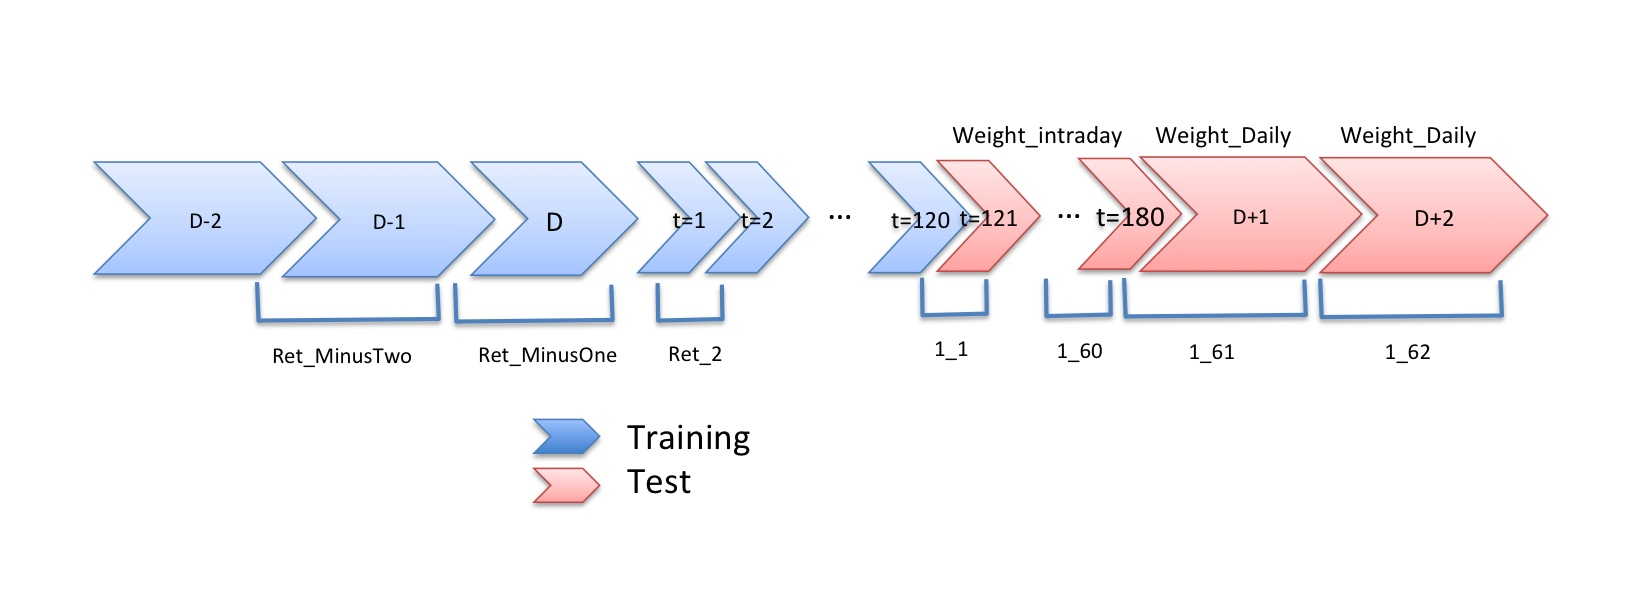

In [41]:
Image(filename="Presentation1.jpg")

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb


In [3]:
PROJECT_ROOT_DIR = os.path.join(os.path.dirname('__file__'), '.')
PROJECT_DATA_DIR = os.path.join(PROJECT_ROOT_DIR, 'data')

In [4]:
train = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'train_winton.csv')).drop('Id', axis=1)
test = pd.read_csv(os.path.join(PROJECT_DATA_DIR, 'test_2_winton.csv')).drop('Id', axis=1)

In [5]:
train.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,NaN,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,NaN,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,5.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,5.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,4.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [6]:
test.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,1.0,1.412783,-0.056284,NaN,10.0,0.413226,18871,0.2138,11.0,NaN,...,0.000370,-0.000762,NaN,0.000366,-0.002444,-0.001301,-0.000917,0.000762,-0.000556,0.000759
1,NaN,NaN,0.907973,1.002425,7.0,-0.257825,5852,0.2138,13.0,4.0,...,0.000457,0.000003,-0.000007,-0.000003,-0.000012,-0.000463,-0.000003,-0.000002,0.000468,-0.000012
2,NaN,-0.607583,1.076668,0.517865,5.0,0.947340,76935,0.0105,10.0,NaN,...,0.000003,0.000157,-0.000181,0.000003,NaN,0.000164,0.000353,0.000704,-0.000168,-0.000006
3,NaN,2.230240,0.223222,NaN,1.0,NaN,84573,0.3318,13.0,NaN,...,0.000010,-0.000792,-0.000479,0.000017,0.000170,-0.001079,0.000320,0.000006,0.001392,-0.001850
4,NaN,0.360399,0.597896,-0.145497,10.0,0.275744,89615,0.0099,8.0,5.0,...,0.000447,0.000489,-0.000233,-0.000495,0.000057,-0.000050,-0.000011,-0.000377,0.000227,-0.000114


In [7]:
no_col = len(train.columns)
print('train.columns:')
print(train.columns)

print('test.columns:')
print(test.columns)
print(train.info())

print('.' * 50)
print('train:')
print(train.head())
print('.' * 50)
print('test:')
print(test.head())


train.columns:
Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       ...
       'Ret_175', 'Ret_176', 'Ret_177', 'Ret_178', 'Ret_179', 'Ret_180',
       'Ret_PlusOne', 'Ret_PlusTwo', 'Weight_Intraday', 'Weight_Daily'],
      dtype='object', length=210)
test.columns:
Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       ...
       'Ret_111', 'Ret_112', 'Ret_113', 'Ret_114', 'Ret_115', 'Ret_116',
       'Ret_117', 'Ret_118', 'Ret_119', 'Ret_120'],
      dtype='object', length=146)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 210 entries, Feature_1 to Weight_Daily
dtypes: float64(209), int64(1)
memory usage: 64.1 MB
None
..................................................
train:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0        

In [8]:
#for col in train.columns:
#(100 * train.isnull().sum()/len(train)).round(2) 

In [9]:
train.T.head(no_col)

,0,1,2,3,4,5,6,7,8,9,...,39990,39991,39992,39993,39994,39995,39996,39997,39998,39999
Feature_1,NaN,NaN,NaN,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Feature_2,NaN,NaN,-6.967269e-01,-6.943497e-01,-1.736489e+00,NaN,-2.306355e-01,2.582955e+00,-1.879500e-01,2.883570e+00,...,NaN,-7.112782e-01,-7.871670e-01,NaN,1.335217e+00,NaN,7.475562e-01,NaN,-2.145700e-02,1.093868e+00
Feature_3,NaN,NaN,7.395907e-01,1.568248e+00,2.765531e+00,-6.805151e-01,-2.270214e-01,1.573438e-01,-2.598202e-01,8.137834e-01,...,6.019254e-01,6.276700e-01,1.189032e+00,-1.279783e-01,-3.876239e-01,8.223709e-01,-4.894179e-01,-9.147013e-01,1.021284e+00,-6.773911e-01
Feature_4,NaN,NaN,-1.679282e-01,4.790731e-01,1.245280e+00,NaN,-8.412617e-02,6.172607e-01,4.763739e-02,7.967455e-01,...,8.624412e-01,1.022876e+00,1.680224e-01,-1.227303e+00,-4.027978e-01,NaN,-2.671932e-01,-1.013004e+00,NaN,-6.044791e-01
Feature_5,8.000000e+00,3.000000e+00,9.000000e+00,5.000000e+00,7.000000e+00,1.000000e+00,7.000000e+00,8.000000e+00,8.000000e+00,7.000000e+00,...,1.000000e+00,2.000000e+00,1.000000e+01,9.000000e+00,8.000000e+00,1.000000e+00,1.000000e+01,2.000000e+00,3.000000e+00,7.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ret_180,-1.973730e-03,2.660238e-05,7.836977e-04,3.408948e-04,-4.149987e-06,1.192878e-03,6.397184e-04,6.314933e-06,1.844860e-04,-5.974607e-04,...,1.739208e-06,2.507092e-04,-5.580793e-06,1.371740e-04,-5.428889e-04,-8.756578e-04,6.284295e-04,-1.568103e-03,-1.229513e-04,2.760911e-03
Ret_PlusOne,-1.951203e-02,-2.938870e-03,-2.479127e-02,-5.679629e-03,3.610375e-02,3.109753e-02,-1.110526e-02,2.026829e-02,-9.348222e-03,2.240733e-02,...,-2.352126e-03,1.903081e-02,2.926312e-03,2.110774e-02,-1.968007e-02,-2.426975e-02,1.785479e-02,1.160202e-02,-1.887735e-02,2.440521e-02
Ret_PlusTwo,2.884636e-02,-1.025321e-02,1.571074e-02,-2.190458e-03,-2.655160e-02,-6.550781e-03,-3.074454e-02,-5.909260e-02,-2.475470e-02,-1.067427e-02,...,-5.774877e-03,1.818971e-02,5.248594e-03,-1.991872e-04,-4.276521e-04,1.014274e-02,-9.444793e-05,-6.538592e-03,-1.157182e-02,-2.434548e-02
Weight_Intraday,1.251508e+06,1.733950e+06,1.529197e+06,1.711569e+06,1.267270e+06,1.431110e+06,1.719166e+06,1.349917e+06,1.536680e+06,1.370804e+06,...,1.757774e+06,1.569730e+06,1.411322e+06,1.524933e+06,1.332139e+06,1.413891e+06,1.468998e+06,1.812824e+06,1.507918e+06,1.535389e+06


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 210 entries, Feature_1 to Weight_Daily
dtypes: float64(209), int64(1)
memory usage: 64.1 MB


In [11]:
train.shape

(40000, 210)

In [12]:
train.shape, test.shape

((40000, 210), (120000, 146))

In [13]:
def get_percentage_missing(series):
    return round(series.isnull().sum()/len(series), 2)

In [14]:
def delete_na(df, thresh=0.4):
    for col in df.columns.tolist():
        if get_percentage_missing(df[col]) > thresh:
            print(get_percentage_missing(df[col]))
            print('Deleting Column {}'.format(col))
            df.drop(col, axis=1, inplace=True)
    return df

In [15]:
xtrain = train.iloc[:, :146] # pick the first 147 columns as input x
#print(xtrain.shape)
#print(xtrain.head())
ytrain = train.iloc[:, 146:] # pick from column 147 to the end for output y
#print(ytrain.head())
xtrain.shape, ytrain.shape

((40000, 146), (40000, 64))

In [16]:
#xtrain = xtrain[xtrain.columns[xtrain.isnull().any()].tolist()]

In [17]:
xtrain.drop(['Feature_1', 'Feature_10'], axis=1, inplace=True)
test.drop(['Feature_1', 'Feature_10'], axis=1, inplace=True)

In [18]:
xtrain.shape, test.shape

((40000, 144), (120000, 144))

# First version, do not use features 1-25

In [19]:
# the column index might need to be changed because we deleted column id
#xtrain = xtrain.iloc[:, 25:] # note xtrain.iloc[...]

In [20]:
print(xtrain.shape)

xtrain.head()

(40000, 144)


,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_11,Feature_12,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,NaN,0.49,...,NaN,0.000700,-0.000843,0.000268,-0.000415,-0.001133,0.000004,-0.000137,-0.000009,1.340780e-04
1,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,-0.409923,0.71,...,-0.000010,0.000249,0.000492,-0.000022,0.000046,-0.000294,-0.000366,-0.000125,-0.000007,2.558108e-04
2,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,-0.473024,0.03,...,0.000250,-0.000138,-0.000266,0.000786,0.001702,-0.000271,-0.000530,-0.000666,-0.000270,-3.718829e-04
3,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,-2.138383,0.00,...,-0.000571,0.000288,0.000006,0.000148,-0.000260,0.000387,-0.000435,-0.000689,0.000153,2.220483e-04
4,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,-4.795565,0.97,...,-0.000014,0.001210,0.000011,-0.000005,-0.000011,0.000003,-0.001229,-0.000003,0.001208,-4.473375e-07


In [21]:
test.head()

,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_11,Feature_12,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,1.412783,-0.056284,NaN,10.0,0.413226,18871,0.2138,11.0,-0.229910,0.97,...,0.000370,-0.000762,NaN,0.000366,-0.002444,-0.001301,-0.000917,0.000762,-0.000556,0.000759
1,NaN,0.907973,1.002425,7.0,-0.257825,5852,0.2138,13.0,-0.971909,0.93,...,0.000457,0.000003,-0.000007,-0.000003,-0.000012,-0.000463,-0.000003,-0.000002,0.000468,-0.000012
2,-0.607583,1.076668,0.517865,5.0,0.947340,76935,0.0105,10.0,-1.096276,0.88,...,0.000003,0.000157,-0.000181,0.000003,NaN,0.000164,0.000353,0.000704,-0.000168,-0.000006
3,2.230240,0.223222,NaN,1.0,NaN,84573,0.3318,13.0,-0.509942,0.76,...,0.000010,-0.000792,-0.000479,0.000017,0.000170,-0.001079,0.000320,0.000006,0.001392,-0.001850
4,0.360399,0.597896,-0.145497,10.0,0.275744,89615,0.0099,8.0,-1.188949,0.64,...,0.000447,0.000489,-0.000233,-0.000495,0.000057,-0.000050,-0.000011,-0.000377,0.000227,-0.000114


In [22]:
cols = 0
for col in xtrain.columns:
    if col.startswith('Feature'):
        cols += 1
print(cols)

23


In [23]:
xtrain = xtrain.iloc[:, cols:]
#xtest = test.iloc[:, cols:]
#print(xtrain.shape, xtest.shape)
xtrain.head()

,Ret_MinusTwo,Ret_MinusOne,Ret_2,Ret_3,Ret_4,Ret_5,Ret_6,Ret_7,Ret_8,Ret_9,...,Ret_111,Ret_112,Ret_113,Ret_114,Ret_115,Ret_116,Ret_117,Ret_118,Ret_119,Ret_120
0,0.055275,-0.010770,0.000003,-0.000734,-0.000738,-0.000007,0.000423,0.000438,-0.000076,0.000645,...,NaN,0.000700,-0.000843,0.000268,-0.000415,-0.001133,0.000004,-0.000137,-0.000009,1.340780e-04
1,0.009748,0.002987,-0.000487,0.000475,0.000002,-0.000002,-0.000523,-0.000255,-0.000008,0.000048,...,-0.000010,0.000249,0.000492,-0.000022,0.000046,-0.000294,-0.000366,-0.000125,-0.000007,2.558108e-04
2,0.003077,0.006181,-0.000782,-0.000402,0.000807,0.000400,0.000656,-0.001177,0.001198,0.000610,...,0.000250,-0.000138,-0.000266,0.000786,0.001702,-0.000271,-0.000530,-0.000666,-0.000270,-3.718829e-04
3,0.000984,0.014106,0.000277,-0.000088,-0.000199,-0.000301,0.000711,-0.000431,-0.000144,0.000340,...,-0.000571,0.000288,0.000006,0.000148,-0.000260,0.000387,-0.000435,-0.000689,0.000153,2.220483e-04
4,-0.018224,0.011065,-0.001232,0.000002,-0.001205,-0.000021,0.000005,0.000623,-0.001843,0.000005,...,-0.000014,0.001210,0.000011,-0.000005,-0.000011,0.000003,-0.001229,-0.000003,0.001208,-4.473375e-07


In [24]:
ytrain.head()

,Ret_121,Ret_122,Ret_123,Ret_124,Ret_125,Ret_126,Ret_127,Ret_128,Ret_129,Ret_130,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
0,-0.000137,-0.000565,-0.000704,-0.005605,0.000826,0.001966,0.002676,0.000422,-0.000428,-0.000539,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
1,0.000261,0.000238,-0.000113,-0.000248,-0.000351,-0.000003,-0.000002,0.000267,0.000263,-0.000240,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
2,0.000271,0.000126,0.000655,-0.000515,-0.000924,-0.000769,0.000282,-0.000120,0.000408,-0.000267,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
3,0.000210,-0.000301,-0.000142,0.000068,-0.000508,-0.000122,0.000295,0.000297,-0.000199,-0.000217,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
4,0.000011,0.000013,0.000622,0.000612,-0.001207,0.001233,-0.001234,-0.000003,0.001226,0.000009,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [25]:
#numnames = xtrain.select_dtypes(exclude=object).columns.tolist()

In [26]:
#numnames[:5]

      Ret_2     Ret_3     Ret_4     Ret_5     Ret_6     Ret_7     Ret_8  \
0  0.000003 -0.000734 -0.000738 -0.000007  0.000423  0.000438 -0.000076   

      Ret_9    Ret_10    Ret_11  ...  Ret_111  Ret_112   Ret_113   Ret_114  \
0  0.000645 -0.000006  0.000006  ...      NaN   0.0007 -0.000843  0.000268   

    Ret_115   Ret_116   Ret_117   Ret_118   Ret_119   Ret_120  
0 -0.000415 -0.001133  0.000004 -0.000137 -0.000009  0.000134  

[1 rows x 119 columns]


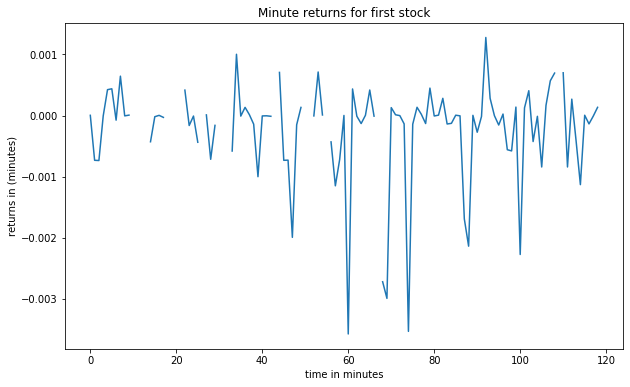

In [27]:
print(xtrain.iloc[:1, 2:].head())
plt.figure(figsize=(10, 6))
plt.title('Minute returns for first stock')
plt.plot(xtrain.iloc[:1, 2:].values.flatten())
plt.xlabel('time in minutes')
plt.ylabel('returns in (minutes)');

### plot minute returns for first 5 rows = 5 stocks

In [28]:
def plot_stocks(xtrain, row=1, colstart=2, endcol=None):
    plt.figure(figsize=(10, 6))
    plt.title('Minute stock returns')
    plt.plot(xtrain.iloc[:row, colstart:endcol].values.flatten())
    plt.xlabel('time in minutes')
    plt.ylabel('returns in (minutes)');

In [29]:
#def run_plot(xtrain, start=1, end=10):
#    for i in range(start, end):
#        plot_stocks(xtrain, row=i)

      Ret_2     Ret_3     Ret_4     Ret_5     Ret_6     Ret_7     Ret_8  \
0  0.000003 -0.000734 -0.000738 -0.000007  0.000423  0.000438 -0.000076   

      Ret_9    Ret_10    Ret_11  ...  Ret_111  Ret_112   Ret_113   Ret_114  \
0  0.000645 -0.000006  0.000006  ...      NaN   0.0007 -0.000843  0.000268   

    Ret_115   Ret_116   Ret_117   Ret_118   Ret_119   Ret_120  
0 -0.000415 -0.001133  0.000004 -0.000137 -0.000009  0.000134  

[1 rows x 119 columns]


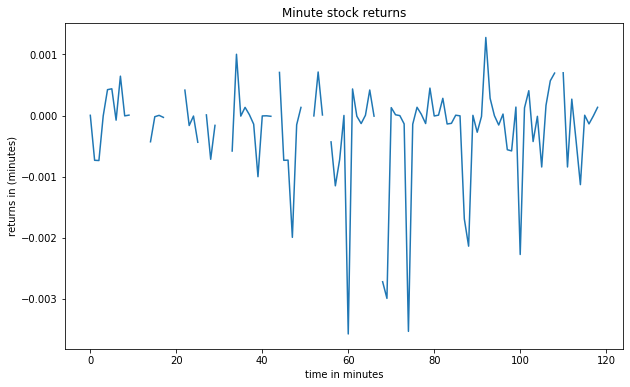

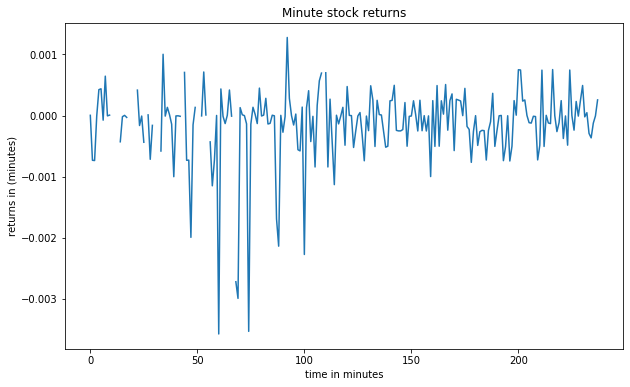

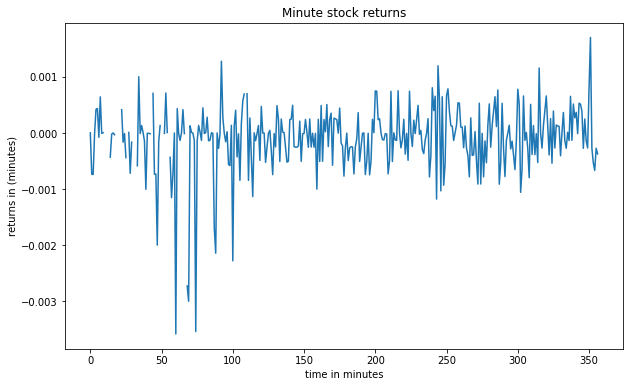

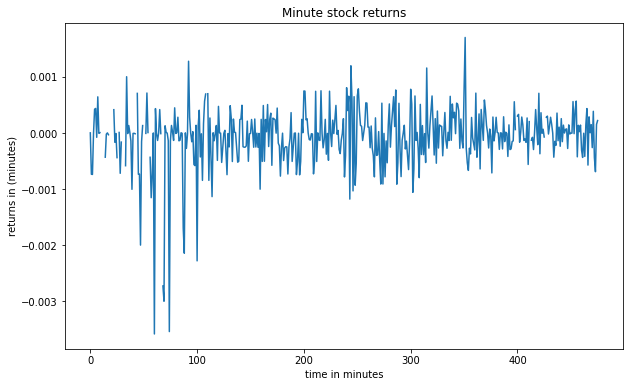

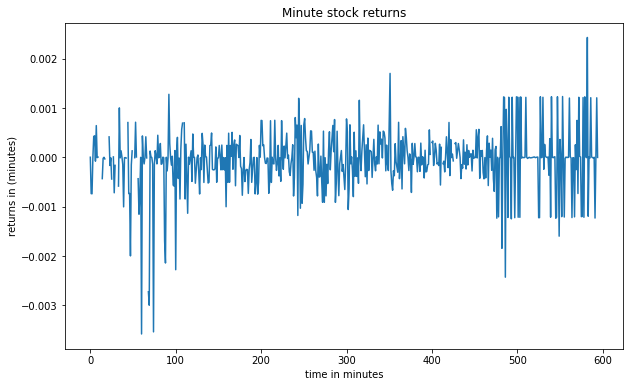

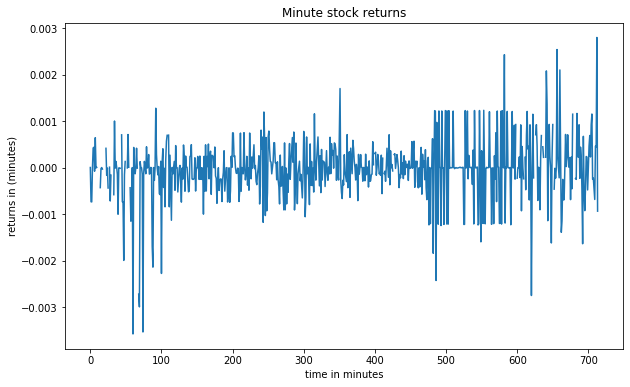

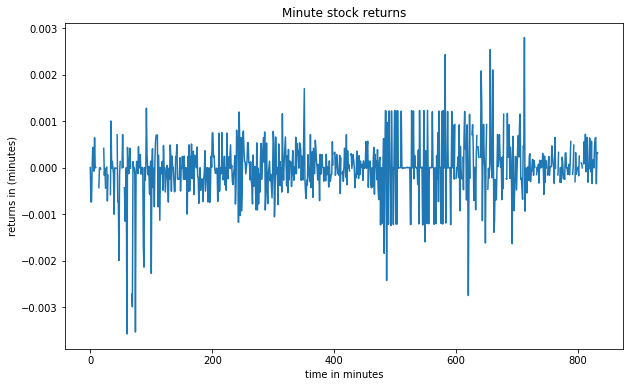

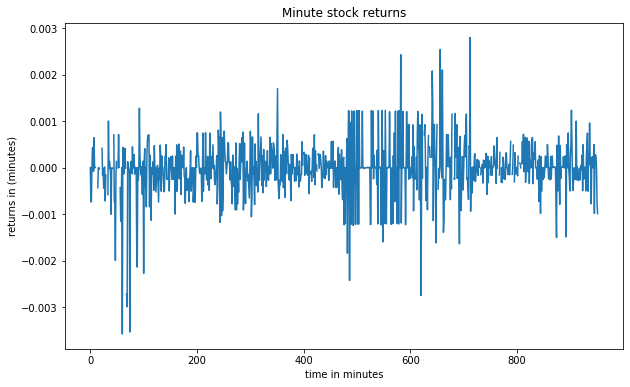

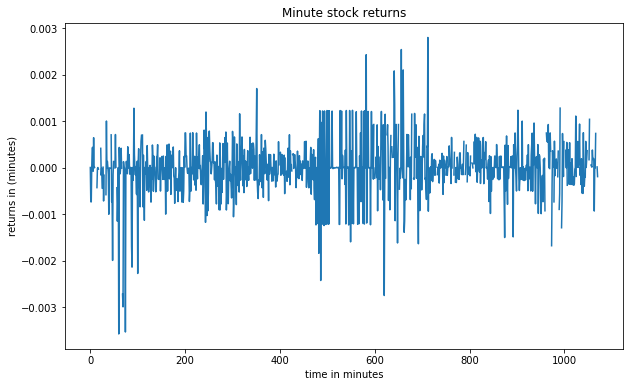

In [30]:
print(xtrain.iloc[:1, 2:].head())
for i in range(1, 5):
    plot_stocks(xtrain, row=i)

      Ret_2     Ret_3     Ret_4     Ret_5     Ret_6     Ret_7     Ret_8  \
0  0.000003 -0.000734 -0.000738 -0.000007  0.000423  0.000438 -0.000076   

      Ret_9    Ret_10    Ret_11  ...  Ret_111  Ret_112   Ret_113   Ret_114  \
0  0.000645 -0.000006  0.000006  ...      NaN   0.0007 -0.000843  0.000268   

    Ret_115   Ret_116   Ret_117   Ret_118   Ret_119   Ret_120  
0 -0.000415 -0.001133  0.000004 -0.000137 -0.000009  0.000134  

[1 rows x 119 columns]


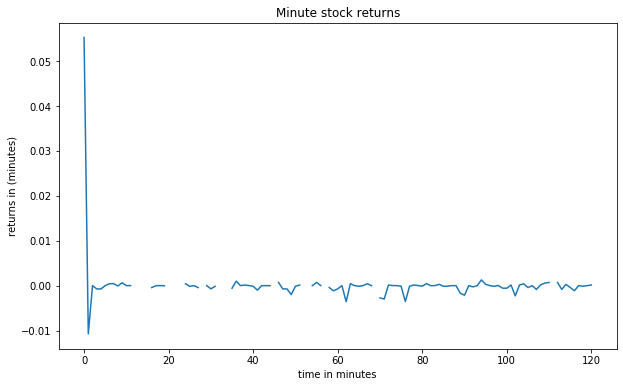

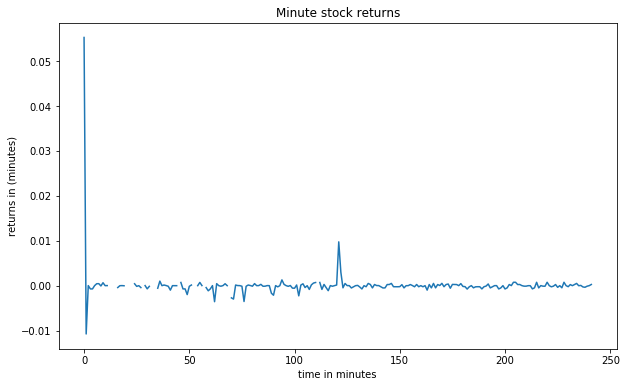

In [31]:
print(xtrain.iloc[:1, 2:].head())
for i in range(1, 3):
    plot_stocks(xtrain, row=i, colstart=None)

## outputs

..................................................
(40000, 64)
    Ret_121   Ret_122   Ret_123   Ret_124   Ret_125   Ret_126   Ret_127  \
0 -0.000137 -0.000565 -0.000704 -0.005605  0.000826  0.001966  0.002676   

    Ret_128   Ret_129   Ret_130  ...   Ret_171   Ret_172   Ret_173   Ret_174  \
0  0.000422 -0.000428 -0.000539  ...  0.001539 -0.000142  0.000861  0.000544   

    Ret_175   Ret_176   Ret_177   Ret_178   Ret_179   Ret_180  
0 -0.002688  0.002246 -0.000838 -0.000695  0.000003 -0.001974  

[1 rows x 60 columns]


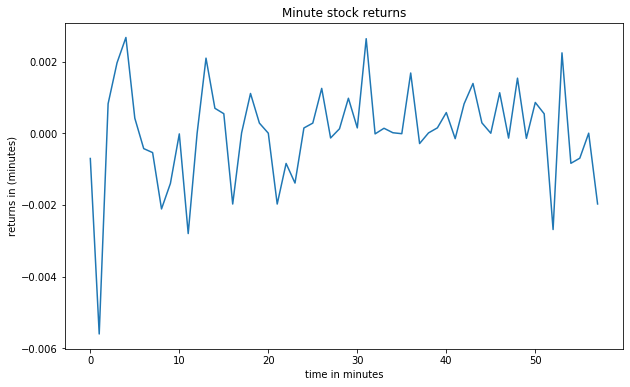

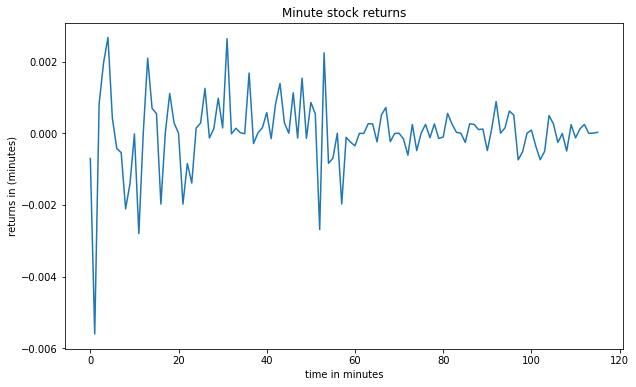

In [32]:
#print(ytrain.head())
print('.' * 50)
print(ytrain.shape)
print(ytrain.iloc[:1, :60].head())
for i in range(1, 3):
    plot_stocks(ytrain, row=i, endcol=60)

..................................................
(40000, 64)
    Ret_121   Ret_122   Ret_123   Ret_124   Ret_125   Ret_126   Ret_127  \
0 -0.000137 -0.000565 -0.000704 -0.005605  0.000826  0.001966  0.002676   

    Ret_128   Ret_129   Ret_130  ...   Ret_173   Ret_174   Ret_175   Ret_176  \
0  0.000422 -0.000428 -0.000539  ...  0.000861  0.000544 -0.002688  0.002246   

    Ret_177   Ret_178   Ret_179   Ret_180  Ret_PlusOne  Ret_PlusTwo  
0 -0.000838 -0.000695  0.000003 -0.001974    -0.019512     0.028846  

[1 rows x 62 columns]


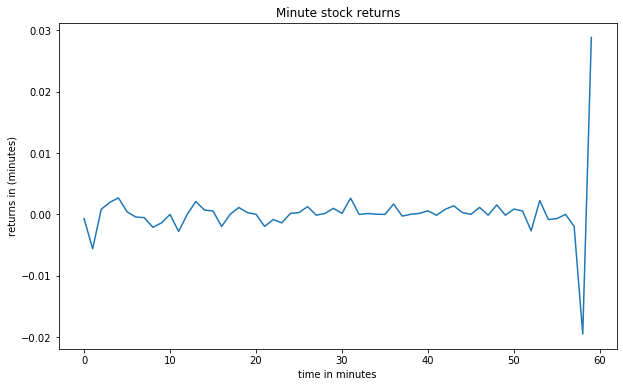

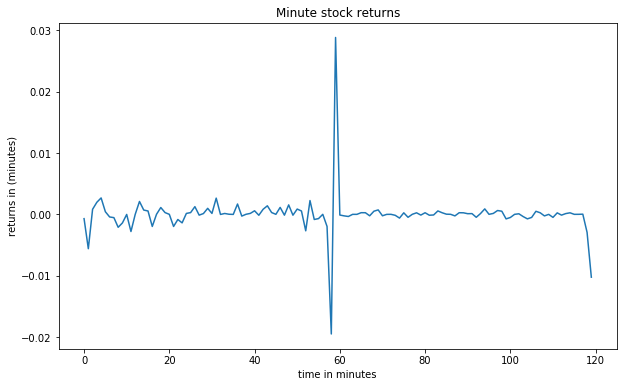

In [33]:
#print(ytrain.head())
print('.' * 50)
print(ytrain.shape)
print(ytrain.iloc[:1, :62].head())
for i in range(1, 3):
    plot_stocks(ytrain, row=i, endcol=62)

In [34]:
#print(ytrain.columns)
y1 = ytrain['Ret_PlusOne'] # D + 1 returns
y2 = ytrain['Ret_PlusTwo'] # D + 2 returns

print(y1.shape, y2.shape)
print()
print(y1.head(2))
print()
print(y2.head(2))

(40000,) (40000,)

0   -0.019512
1   -0.002939
Name: Ret_PlusOne, dtype: float64

0    0.028846
1   -0.010253
Name: Ret_PlusTwo, dtype: float64


# Machine learning

In [35]:
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor # used for transforming the target variable
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from dask.distributed import Client
from scipy.stats import uniform


np.random.seed(100)

# Predict: D + 1 Returns

In [36]:
xtrain, xtest, ytrain1, ytest1 = train_test_split(xtrain, y1, shuffle=True)

In [37]:
xtrain.shape, xtest.shape, ytrain1.shape, ytest1.shape

((30000, 121), (10000, 121), (30000,), (10000,))

In [38]:
imp = SimpleImputer(strategy='median')
xtrain = imp.fit_transform(xtrain)
xtest = imp.transform(xtest)

scaler = QuantileTransformer(output_distribution='normal')
xtrain = scaler.fit_transform(xtrain)
xtest = scaler.transform(xtest)

# Scores and hyperparameter optimization
* Randomized search, See the theory on how it is done with deep learning
http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf

* with reinforcement learning
https://arxiv.org/pdf/1906.11527.pdf

* R2 (0, 1), where 1 is good fit
* Explainde variance score (0, 1) where 1 is good fit

In [40]:
transformer = QuantileTransformer(output_distribution='normal')
# we might need to do grid or random search
regressor = RandomForestRegressor() #Ridge(alpha=0.1)


param_dist = {"max_depth": sp_randint(5, 10),
              "max_features": sp_randint(2, 8),
              "min_samples_split": sp_randint(5, 10),
              "bootstrap": [True, False],
              "criterion": ["mae", "mse"], 
              "n_estimators": sp_randint(60, 70)}

#reg.fit(xtrain, ytrain1)


xgb_reg = xgb.XGBRegressor(objective='reg:squarederror')

rxgb_dict = {"subsample": uniform(0.0, 0.99),
             "num_round": sp_randint(10, 700),
             "min_child_weight": uniform(1.0, 5.0),
             "max_depth": sp_randint(3, 9),
             "learning_rate": uniform(0.05, 0.08),
             "colsample_bytree": uniform(0.2, 0.6)}

# use the train examples only
# for hyper parameter optimization
train_samples = 5000
test_samples = 6000
xtr = xtrain[:train_samples, :]
ytr = ytrain1[:train_samples]

xts = xtrain[train_samples:test_samples, :]
yts = ytrain1[train_samples:test_samples]

param_dicts = [param_dist, rxgb_dict]
models = [regressor, xgb_reg]


n_iter_search = 10
for regressor, param_dist in zip(models, param_dicts):
    reg = RandomizedSearchCV(regressor, 
                             param_distributions=param_dist, 
                             n_iter=n_iter_search, 
                             cv=3, 
                             iid=False, 
                             verbose=10, 
                             n_jobs=-1)

    reg.fit(xtr, ytr)
    print('Done with training.')
    pred_train = reg.predict(xtr)
    pred_test = reg.predict(xts)

    sctest = r2_score(yts, pred_test)
    sctrain = r2_score(ytr, pred_train)

    mse_train = mean_squared_error(ytr, pred_train)
    mse_test = mean_squared_error(yts, pred_test)

    ex_variance_train = explained_variance_score(ytr, pred_train)
    ex_variance_test = explained_variance_score(yts, pred_test)

    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    print('R2 score train score: {} score test set: {}'.format(sctrain, sctest))
    print('Mean-squared error train set: {} test set: {}'.format(mse_train, mse_test))
    print('Explained variance train set: {} test set: {}'.format(ex_variance_train, ex_variance_test))
    print('Root means squared error train set {} test set: {}'.format(rmse_train, rmse_test))
    print('Best Score:', reg.best_score_)
    print('Best params:', reg.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:   25.3s remaining:   43.8s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:   35.0s remaining:   35.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:  1.6min remaining:   54.3s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:  1.7min remaining:   30.5s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  2.6min remaining:   17.2s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.7min finished


Done with training.
R2 score train score: 0.24063812950742713 score test set: 0.03994910710956456
Mean-squared error train set: 0.0004447680781090913 test set: 0.0005390748478599497
Explained variance train set: 0.24063906340223418 test set: 0.0401152804741991
Root means squared error train set 0.021089525317301273 test set: 0.023217985439308676
Best Score: 0.039527152307701874
Best params: {'bootstrap': True, 'criterion': 'mse', 'max_depth': 9, 'max_features': 7, 'min_samples_split': 8, 'n_estimators': 67}
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.1s
D:\anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  11 out of  30 | elapsed:    6.2s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:   12.6s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:   14.8s remaining:    4.4s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   15.7s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   16.3s finished
D:\anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a f

Done with training.
R2 score train score: 0.461311240115468 score test set: 0.006655801118092386
Mean-squared error train set: 0.00031551698043173797 test set: 0.0005577692566616255
Explained variance train set: 0.4613639450217052 test set: 0.007318600612249981
Root means squared error train set 0.017762797652164423 test set: 0.023617139044804423
Best Score: 0.04848115966176547
Best params: {'colsample_bytree': 0.20951128683192144, 'learning_rate': 0.08049742607381447, 'max_depth': 5, 'min_child_weight': 5.546883643239502, 'num_round': 194, 'subsample': 0.5915913066395085}
